In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Daily Model
1. Add when there's a signal
2. Potential crash/bear market when there's 2 signals for the past month\

In [5]:
# visualization, not quantifiable
symbol = "^TWII"
data = yf.download(symbol, start='2018-01-01', rounding=2, progress=False)
returns = data[["Close"]].pct_change().dropna()


returns["pct_power_5"] = np.power(returns.Close, 5)
tajm = 242
alpha = 2 / (tajm + 1)
returns['cumsum_bm'] = returns.Close.cumsum()
returns['ma_cumsum_bm'] = returns.cumsum_bm.rolling(60).mean()
returns['pct_for_calculating_profit'] = returns.Close.shift(-2)

returns["pct_power_5_ema"] = returns["pct_power_5"].ewm(alpha=alpha, adjust=False).mean()
returns['pct_power_5_ema_shift_1'] = returns.pct_power_5_ema.shift(1)

returns['signal'] = returns.apply(lambda row: 1 if row['pct_power_5_ema'] > row['pct_power_5_ema_shift_1']*1.01 or row['pct_power_5_ema'] > 0 else -1, axis=1)

returns['strat_pct'] = returns.signal * returns.pct_for_calculating_profit

k = 0
u = -1

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                     subplot_titles=symbol)

fig.add_trace(go.Scatter(
    x=returns.index[k:u],
    y=returns.iloc[k:u].cumsum_bm,
    mode='lines',
    name='Close Price'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=returns.index[k:u],
    y=returns.iloc[k:u]['signal'],
    mode='lines',
    name='Signal'
), row=2, col=1)

fig.update_layout(
    title=symbol,
    template="plotly_white",
    height=600
)

fig.update_xaxes(title_text="Index", row=2, col=1)
fig.update_yaxes(title_text="Signal", row=2, col=1)

fig.show()

# Monthly Model
1. Add to the position when there's a signal with abnormal plunges/dips
2. bear market when there's 2 signals for the past 3 months, reverse when there's abnormal dips

In [30]:
# visualization, not quantifiable - Monthly Version
symbol = "^TWII"
data = yf.download(symbol, start='2016-01-01', rounding=2, progress=False)
returns = data[["Close"]].pct_change().dropna()
returns = returns.resample("ME").sum()

returns["pct_power_5"] = np.power(returns.Close, 5)
tajm = 3
alpha = 2 / (tajm + 1)
returns['cumsum_bm'] = returns.Close.cumsum()
returns['ma_cumsum_bm'] = returns.cumsum_bm.rolling(60).mean()
returns['pct_for_calculating_profit'] = returns.Close.shift(-2)

returns["pct_power_5_ema"] = returns["pct_power_5"].ewm(alpha=alpha, adjust=False).mean()
returns['pct_power_5_ema_shift_1'] = returns.pct_power_5_ema.shift(1)

returns['signal'] = returns.apply(lambda row: 1 if row['pct_power_5_ema'] > row['pct_power_5_ema_shift_1']*1.01 or row['pct_power_5_ema'] > 0 else -1, axis=1)

returns['strat_pct'] = returns.signal * returns.pct_for_calculating_profit

k = 0
u = -1

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                     subplot_titles=symbol)

fig.add_trace(go.Scatter(
    x=returns.index[k:u],
    y=returns.iloc[k:u].cumsum_bm,
    mode='lines',
    name='Close Price'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=returns.index[k:u],
    y=returns.iloc[k:u]['signal'],
    mode='lines',
    name='Signal'
), row=2, col=1)

fig.update_layout(
    title=symbol,
    template="plotly_white",
    height=600
)

fig.update_xaxes(title_text="Index", row=2, col=1)
fig.update_yaxes(title_text="Signal", row=2, col=1)

fig.show()

In [251]:
# # 抓動能
# # 1.
# df_1['rolling_1c_5m'] = df_1['rolling_1c'].rolling(5).mean()
# # 2.
# df_1['rolling_1c_5m_tangent'] = df_1['rolling_1c_5m'].diff().dropna()

# df_1['signal'] = df_1["rolling_1c_5m"].apply(lambda x: 1 if x > -0 else 0)

In [308]:
# Quantifiable version -> IC_rolling_5_reversal
symbol = "NVDA"
data = yf.download(symbol, start='2016-01-01', rounding=2, progress=False)
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1)) # index -> 當天的股價變化（前一天收盤和今天收盤)
df_1 = data[["log_return"]].dropna()
df_1 = df_1.resample("MS").sum()
df_1['bm'] = df_1['log_return'].cumsum()
df_1['ret_for_cal'] = df_1['log_return'].shift(-2)
df_1['signal_val'] = df_1['log_return']
## 如果策略是always long, then IC could finally become the return itself




rolling = 5
list_rolling_1c = [None] * len(df_1)

for i in range(len(df_1)):
    if i < rolling:
        list_rolling_1c[i] = 0
    else:
        df_copy = df_1.iloc[i-rolling:i].dropna(subset=['ret_for_cal', 'signal_val'])
        if len(df_copy) < 2:  # 相关系数需要至少两个数据点
            list_rolling_1c[i] = np.nan
        else:
            try:
                d = np.corrcoef(df_copy['ret_for_cal'], df_copy['signal_val'])
                list_rolling_1c[i] = d[0, 1] if not np.isnan(d[0, 1]) else 0
            except:
                list_rolling_1c[i] = np.nan


# origin
df_1['rolling_1c'] = list_rolling_1c
df_1['rolling_1c'] = df_1['rolling_1c'].fillna(0)
df_1['rolling_1c_5m'] = df_1['rolling_1c'].rolling(5).mean()
df_1['rolling_1c_5m_tangent'] = df_1['rolling_1c_5m'].diff().dropna()
df_1['signal'] = df_1["rolling_1c_5m"].apply(lambda x: 1 if x < -0 else 0)
df_1['cumsum'] = (df_1['signal'] * df_1['ret_for_cal']).cumsum()


# 绘图函数
def plotly_df(df, bar, line):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df.index, y=df[bar], name="1c",
        yaxis="y2", marker=dict(color="red", opacity=0.6)))    
    fig.add_trace(go.Scatter(
        x=df.index, y=df["rolling_1c_5m"], name="rolling_1c",
        yaxis="y2", line=dict(color="green")))
    fig.add_trace(go.Scatter(
        x=df.index, y=df[line], mode="lines", name="log_return",
        yaxis="y1", line=dict(color="blue")))
    fig.add_trace(go.Scatter(
        x=df.index, y=df['bm'], mode="lines", name="bm",
        yaxis="y1", line=dict(color="black")))

    fig.update_layout(title="1",
                      xaxis=dict(title="Date"),
                      yaxis=dict(title="Cumulative Change"),
                      yaxis2=dict(title="IR", overlaying="y", side="right"),
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                     )
    fig.show()

plotly_df(df_1, "rolling_1c", "cumsum")


In [302]:
df_1['signal'] = df_1["predicted_rolling_1c_5m_lag1"].cumsum().apply(lambda x: 1 if x > -0 else 0)
df_1['cumsum'] = (df_1['signal'] * df_1['ret_for_cal']).cumsum()


# 绘图函数
def plotly_df(df, bar, line):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df.index, y=df[bar], name="1c",
        yaxis="y2", marker=dict(color="red", opacity=0.6)))    
    fig.add_trace(go.Scatter(
        x=df.index, y=df["predicted_rolling_1c_5m_lag1"], name="rolling_1c",
        yaxis="y2", line=dict(color="green")))
    fig.add_trace(go.Scatter(
        x=df.index, y=df[line], mode="lines", name="log_return",
        yaxis="y1", line=dict(color="blue")))
    fig.add_trace(go.Scatter(
        x=df.index, y=df['bm'], mode="lines", name="bm",
        yaxis="y1", line=dict(color="black")))

    fig.update_layout(title="1",
                      xaxis=dict(title="Date"),
                      yaxis=dict(title="Cumulative Change"),
                      yaxis2=dict(title="IR", overlaying="y", side="right"),
                      legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                     )
    fig.show()

plotly_df(df_1, "rolling_1c", "cumsum")

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_45022/1330590630.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_45022/1330590630.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



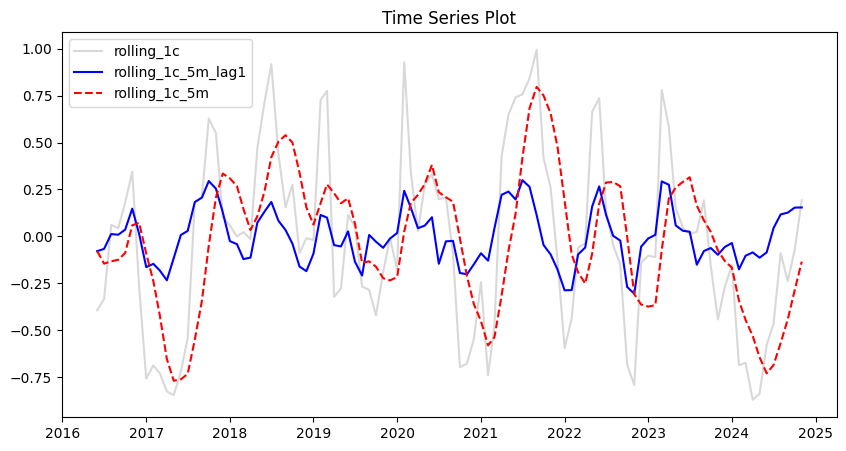


=== Augmented Dickey-Fuller (ADF) Test ===
ADF Statistic: -5.149676240626418
p-value: 1.1128713668000468e-05
Critical Values: {'1%': np.float64(-3.503514579651927), '5%': np.float64(-2.893507960466837), '10%': np.float64(-2.583823615311909)}
=> 時間序列是穩定的（拒絕單位根假設）

=== KPSS Test ===
KPSS Statistic: 0.024406983660970185
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> 時間序列可能是穩定的

=== Phillips-Perron (PP) Test ===
PP Statistic: -3.0139467773639894
p-value: 0.033612315216280816
Critical Values: {'1%': np.float64(-3.4968181663902103), '5%': np.float64(-2.8906107514600103), '10%': np.float64(-2.5822770483285953)}
=> 時間序列是穩定的（拒絕單位根假設）
<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.014
P-value                         0.034
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%)

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_45022/3517672396.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [293]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import arch.unitroot as at
def stationarity_tests(series):
    """
    Perform ADF, KPSS, and PP tests on a given time series.
    """
    print("\n=== Augmented Dickey-Fuller (ADF) Test ===")
    adf_test = ts.adfuller(series.dropna())
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print(f"Critical Values: {adf_test[4]}")
    print("=> 時間序列是穩定的（拒絕單位根假設）" if adf_test[1] < 0.05 else "=> 時間序列可能是非穩定的（接受單位根假設）")
    
    print("\n=== KPSS Test ===")
    kpss_test = ts.kpss(series.dropna(), regression="c", nlags="auto")
    print(f"KPSS Statistic: {kpss_test[0]}")
    print(f"p-value: {kpss_test[1]}")
    print(f"Critical Values: {kpss_test[3]}")
    print("=> 時間序列可能是非穩定的（拒絕穩定假設）" if kpss_test[1] < 0.05 else "=> 時間序列可能是穩定的")
    
    print("\n=== Phillips-Perron (PP) Test ===")
    pp_test = at.PhillipsPerron(series.dropna())
    print(f"PP Statistic: {pp_test.stat}")
    print(f"p-value: {pp_test.pvalue}")
    print(f"Critical Values: {pp_test.critical_values}")
    print("=> 時間序列是穩定的（拒絕單位根假設）" if pp_test.pvalue < 0.05 else "=> 時間序列可能是非穩定的（接受單位根假設）")
    print(pp_test.summary)
# 計算滾動相關性的一階差分
df_1['rolling_1c_5m_lag1'] = df_1['rolling_1c_5m'].diff()
df_1 = df_1.dropna()

# 畫出時間序列
plt.figure(figsize=(10, 5))
plt.plot(df_1.index, df_1['rolling_1c'], label="rolling_1c", color='grey', alpha=0.3)
plt.plot(df_1.index, df_1['rolling_1c_5m_lag1'], label="rolling_1c_5m_lag1", color='blue')
plt.plot(df_1.index, df_1['rolling_1c_5m'], label="rolling_1c_5m", color='red', linestyle='dashed')
plt.legend()
plt.title("Time Series Plot")
plt.show()

# 執行穩定性檢驗
stationarity_tests(df_1['rolling_1c_5m_lag1'])

In [294]:
import numpy as np
import pandas as pd
from scipy import stats

def adf_test(diff_series, max_lags=12):
    """
    Augmented Dickey-Fuller (ADF) test implemented from scratch.
    """
    # 差分序列
    n = len(diff_series)
    
    # 初始化 X 矩陣（滯後項）
    X = np.ones((n - max_lags, max_lags))  # 確保 X 的大小一致
    
    # 填充 X 矩陣
    for i in range(1, max_lags + 1):
        shifted = diff_series.shift(i).dropna()  # 移位並丟失NaN
        aligned = shifted.align(diff_series[max_lags:], join='inner')[0]  # 對齊差分序列
        X[:, i - 1] = aligned.values  # 填充 X
    
    Y = diff_series[max_lags:].values  # Y 是差分序列

    # 進行OLS回歸
    X_T = X.T
    beta = np.linalg.inv(X_T.dot(X)).dot(X_T).dot(Y)  # 回歸參數
    residuals = Y - X.dot(beta)  # 殘差
    sigma2 = np.sum(residuals**2) / (n - max_lags - 1)  # 殘差的方差
    adf_statistic = beta[0] / np.sqrt(sigma2)
    
    # 計算 p-value
    p_value = 1 - stats.t.cdf(adf_statistic, df=n - max_lags - 1)
    
    # 臨界值設定（示例：1%、5%、10%的臨界值）
    critical_values = {
        '1%': -3.481,
        '5%': -2.883,
        '10%': -2.579
    }
    
    return {
        'statistic': adf_statistic,
        'p-value': p_value,
        'critical values': critical_values
    }

# 測試函數
result = adf_test(df_1['rolling_1c_5m_lag1'])
print(f"ADF Statistic: {result['statistic']}")
print(f"P-value: {result['p-value']}")
print(f"Critical Values: {result['critical values']}")


ADF Statistic: 11.161006229273417
P-value: 0.0
Critical Values: {'1%': -3.481, '5%': -2.883, '10%': -2.579}


/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_45022/2692368240.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_45022/2692368240.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/U

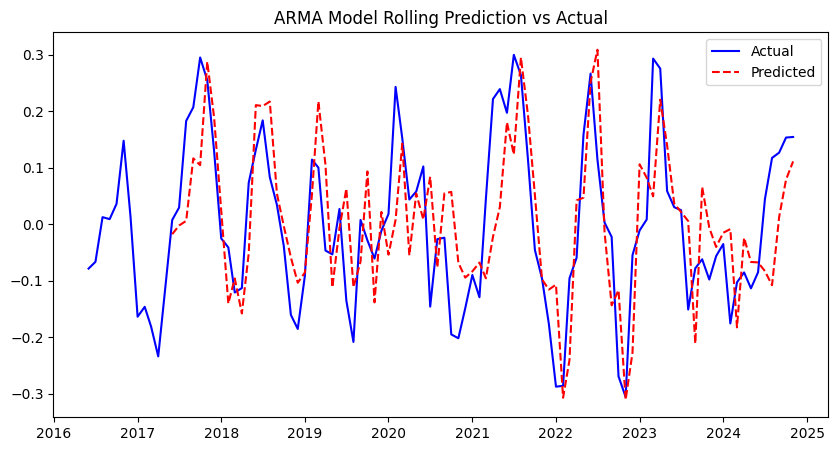

預測結果與實際數據：
            rolling_1c_5m_lag1  predicted_rolling_1c_5m_lag1
Date                                                        
2023-04-01            0.275405                      0.220324
2023-05-01            0.058514                      0.139570
2023-06-01            0.029957                      0.036400
2023-07-01            0.024672                      0.021432
2023-08-01           -0.151259                      0.005399
2023-09-01           -0.078204                     -0.211536
2023-10-01           -0.062308                      0.065731
2023-11-01           -0.098133                     -0.006192
2023-12-01           -0.056692                     -0.040564
2024-01-01           -0.035355                     -0.015369
2024-02-01           -0.175914                     -0.008802
2024-03-01           -0.103124                     -0.182890
2024-04-01           -0.085571                     -0.024130
2024-05-01           -0.113783                     -0.067058
2024-06-01   

In [300]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 使用ARMA模型預測
def predict_with_arma(series, p, q, window_size=12):
    """
    擬合ARMA模型並進行滾動預測
    series: 時間序列
    p: AR階數
    q: MA階數
    window_size: 每次預測使用的數據窗口大小
    """
    predictions = []
    
    # 滾動預測，每次都用最新的window_size個數據進行預測
    for i in range(window_size, len(series)):
        train_data = series[i - window_size:i]  # 提取最近12期的數據
        model = tsa.ARIMA(train_data, order=(p, 0, q))  # ARMA模型，d=0
        results = model.fit()
        prediction = results.forecast(steps=1)[0]  # 預測下一期
        predictions.append(prediction)
    
    # 生成預測結果的Series
    forecast_index = series.index[window_size:]  # 預測結果的日期索引
    forecast_series = pd.Series(predictions, index=forecast_index)
    
    return forecast_series

# 進行滾動ARMA預測
p, q = 2, 1  # 假設我們選擇p=1, q=1
predictions = predict_with_arma(df_1['rolling_1c_5m_lag1'], p, q, window_size=12)

# 將預測結果放回df_1
df_1['predicted_rolling_1c_5m_lag1'] = np.nan
df_1.loc[predictions.index, 'predicted_rolling_1c_5m_lag1'] = predictions.values

# 顯示預測結果
plt.figure(figsize=(10, 5))
plt.plot(df_1.index, df_1['rolling_1c_5m_lag1'], label="Actual", color='blue')
plt.plot(df_1.index, df_1['predicted_rolling_1c_5m_lag1'], label="Predicted", color='red', linestyle='dashed')
plt.legend()
plt.title("ARMA Model Rolling Prediction vs Actual")
plt.show()

# 顯示預測結果的摘要
print("預測結果與實際數據：")
print(df_1[['rolling_1c_5m_lag1', 'predicted_rolling_1c_5m_lag1']].tail(20))  # 顯示最後20條數據
